# GRAVITY data reduction process: Study of variables correlation


**Pablo Marcos-Arenal**

Centro de Astrobiología (INTA-CSIC)


This file intends to cover the correlations in variables involved in  the paper related to the near-infrared K- band observations with the GRAVITY interferometer at Very Large Telescope Interferometer (VLTI) at the Paranal Observatory. 

These observations of Herbig Ae/Be stars provide with spatially and spectrally resolved data of their inner disks.



In [21]:

#Import modules
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import LinearRegression,LassoCV, Lasso
from sklearn.model_selection import train_test_split
import statsmodels.api as sm 
import seaborn as sns
sns.set()


from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats
import pickle

In [3]:
size_luminosity_table = pd.read_csv("./tables/size_luminosity_table_ln.csv", sep=';', header=[0] ,encoding='latin-1')

size_luminosity_table = size_luminosity_table.rename(columns={"ï»¿Star": "Star"})
size_luminosity_table.dtypes


Star                                object
r_hole (mas)                       float64
error r_hole (mas)                  object
Reference r_hole(mas)               object
D Gaia (pc)                        float64
error D Gaia (pc)                  float64
reference distance                  object
T*(K)                                int64
err T*                               int64
R*(Rsun)                           float64
err R*                             float64
log L* (Lsun)                      float64
err logL*(Lsun)                    float64
Reference T*,R*,L*                  object
r_hole (au) (from distance)        float64
err r_hole (au) (from distance)     object
r_hole (R*) (from R*)              float64
err r_hole (R*) (from R*)           object
r_hole-r_star(au)                  float64
err_rhole â rstar (au)            object
DeltaDb (mag)                      float64
errDeltaDb (mag)                    object
MA?                                 object
ref DeltaDb

(0.0, 5.976999999999999)

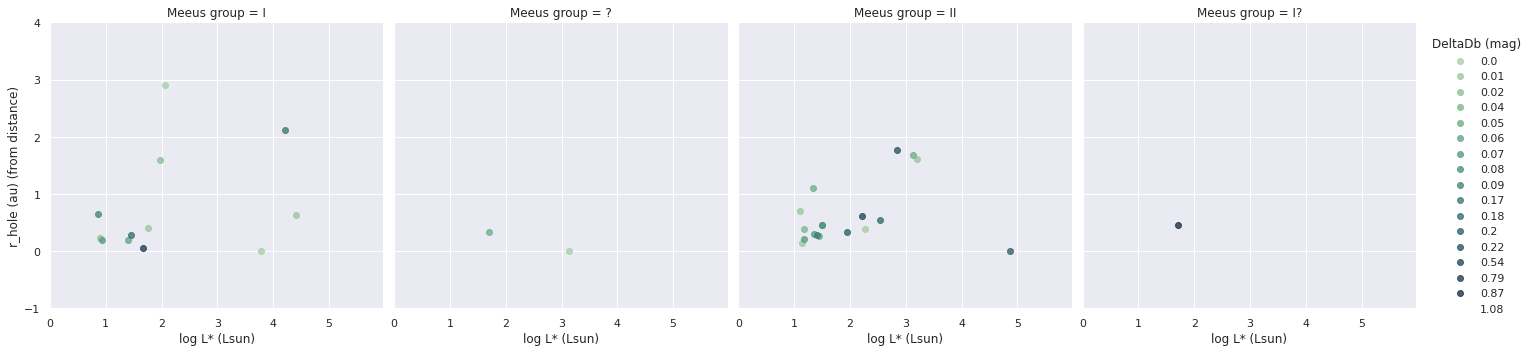

In [4]:
sns.lmplot(x='log L* (Lsun)', y='r_hole (au) (from distance)', data=size_luminosity_table,hue='DeltaDb (mag)',col="Meeus group",fit_reg=False, palette="ch:r=-.5,l=.75") 
plt.ylim(-1, 4)
plt.xlim(0, None)

## Study of correlation between log L* (Lsun), r_hole (au) and distance

In [5]:
x1=size_luminosity_table['D Gaia (pc)'].to_numpy()
x2=size_luminosity_table['log L* (Lsun)'].to_numpy()


X= np.array([x1,x2])
X=X.T
y=size_luminosity_table['r_hole (au) (from distance)'].to_numpy()

f_test, p_val = f_regression(X, y)
print("f_test: ", f_test, p_val)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
print("mi test: ", mi)
mi /= np.max(mi)


f_test:  [ 8.75285729 11.78584321] [0.00486943 0.00127288]
mi test:  [0.36460714 0.21297068]


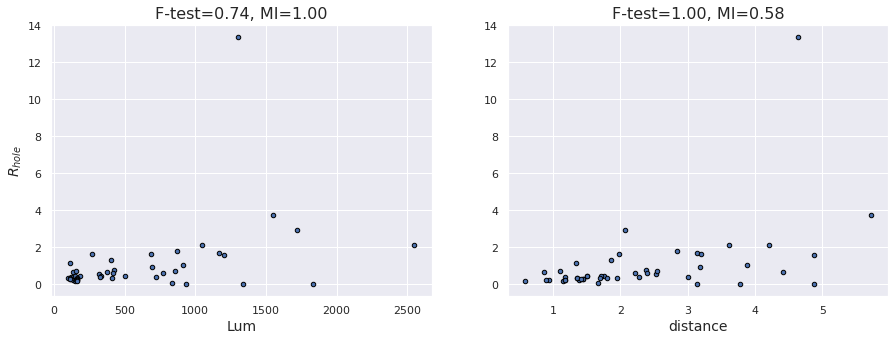

In [6]:
plt.figure(figsize=(15, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    if i == 0:
        plt.ylabel("$R_{hole}$", fontsize=14)
        plt.xlabel("Lum", fontsize=14)
    else:
        plt.xlabel("distance", fontsize=14)
        
        
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
              fontsize=16)
plt.show()

## Correlation matrix
Pearson correlation matrix between variables in our sample.
Let's remove the variables not suitable for correlation (and the errors).
Let's also remove uncomplete columns and non numeric values.

In [7]:
cba_table=size_luminosity_table[[ 'Star','r_hole (mas)','error r_hole (mas)','D Gaia (pc)','error D Gaia (pc)',
                                 'T*(K)','err T*','R*(Rsun)','err R*','log L* (Lsun)','err logL*(Lsun)',
                                 'r_hole (au) (from distance)','err r_hole (au) (from distance)','r_hole (R*) (from R*)','err r_hole (R*) (from R*)',
                                 'r_hole-r_star(au)','err_rhole â rstar (au)','DeltaDb (mag)','errDeltaDb (mag)']].copy()

cba_table_noerror=size_luminosity_table[[ 'Star','r_hole (mas)','D Gaia (pc)',
                                 'T*(K)','R*(Rsun)','log L* (Lsun)',
                                 'r_hole (au) (from distance)','r_hole (R*) (from R*)',
                                 'r_hole-r_star(au)','DeltaDb (mag)']].copy()

cba_table_noerror.dropna()
cba_table_noerror = cba_table_noerror._get_numeric_data() #drop non-numeric cols

#Check incomplete columns
#cba_table_noerror.info

#Select complete columns
#df = df[[ 'Star','r_hole (mas)','D Gaia (pc)', 'T*(K)','R*(Rsun)','log L* (Lsun)',
#                                 'r_hole (au) (from distance)','r_hole (R*) (from R*)',
#                                 'r_hole-r_star(au)']].dropna()

Scale values to unit and calculate correlation matrix. Plot the correlation matrix in a heat map.

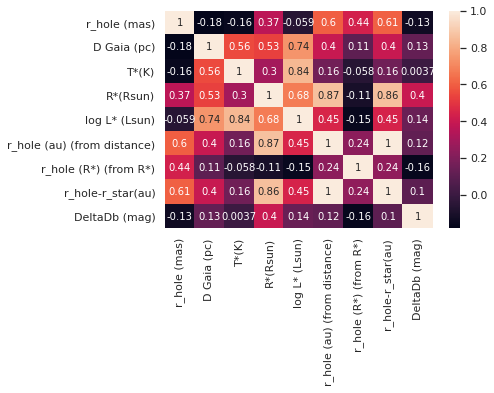

In [8]:

#scaler =StandardScaler()

#cba_table_noerror_scaled = scaler.fit_transform(cba_table_noerror)

#cba_table_noerror_scaled_df = pd.DataFrame(cba_table_noerror_scaled)
#correlation_mat = cba_table_noerror_scaled_df.corr()
correlation_mat = cba_table_noerror.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()


## Pair plot 


/pcdisk/stark/pmarcos/anaconda3/envs/DRS_gravity3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


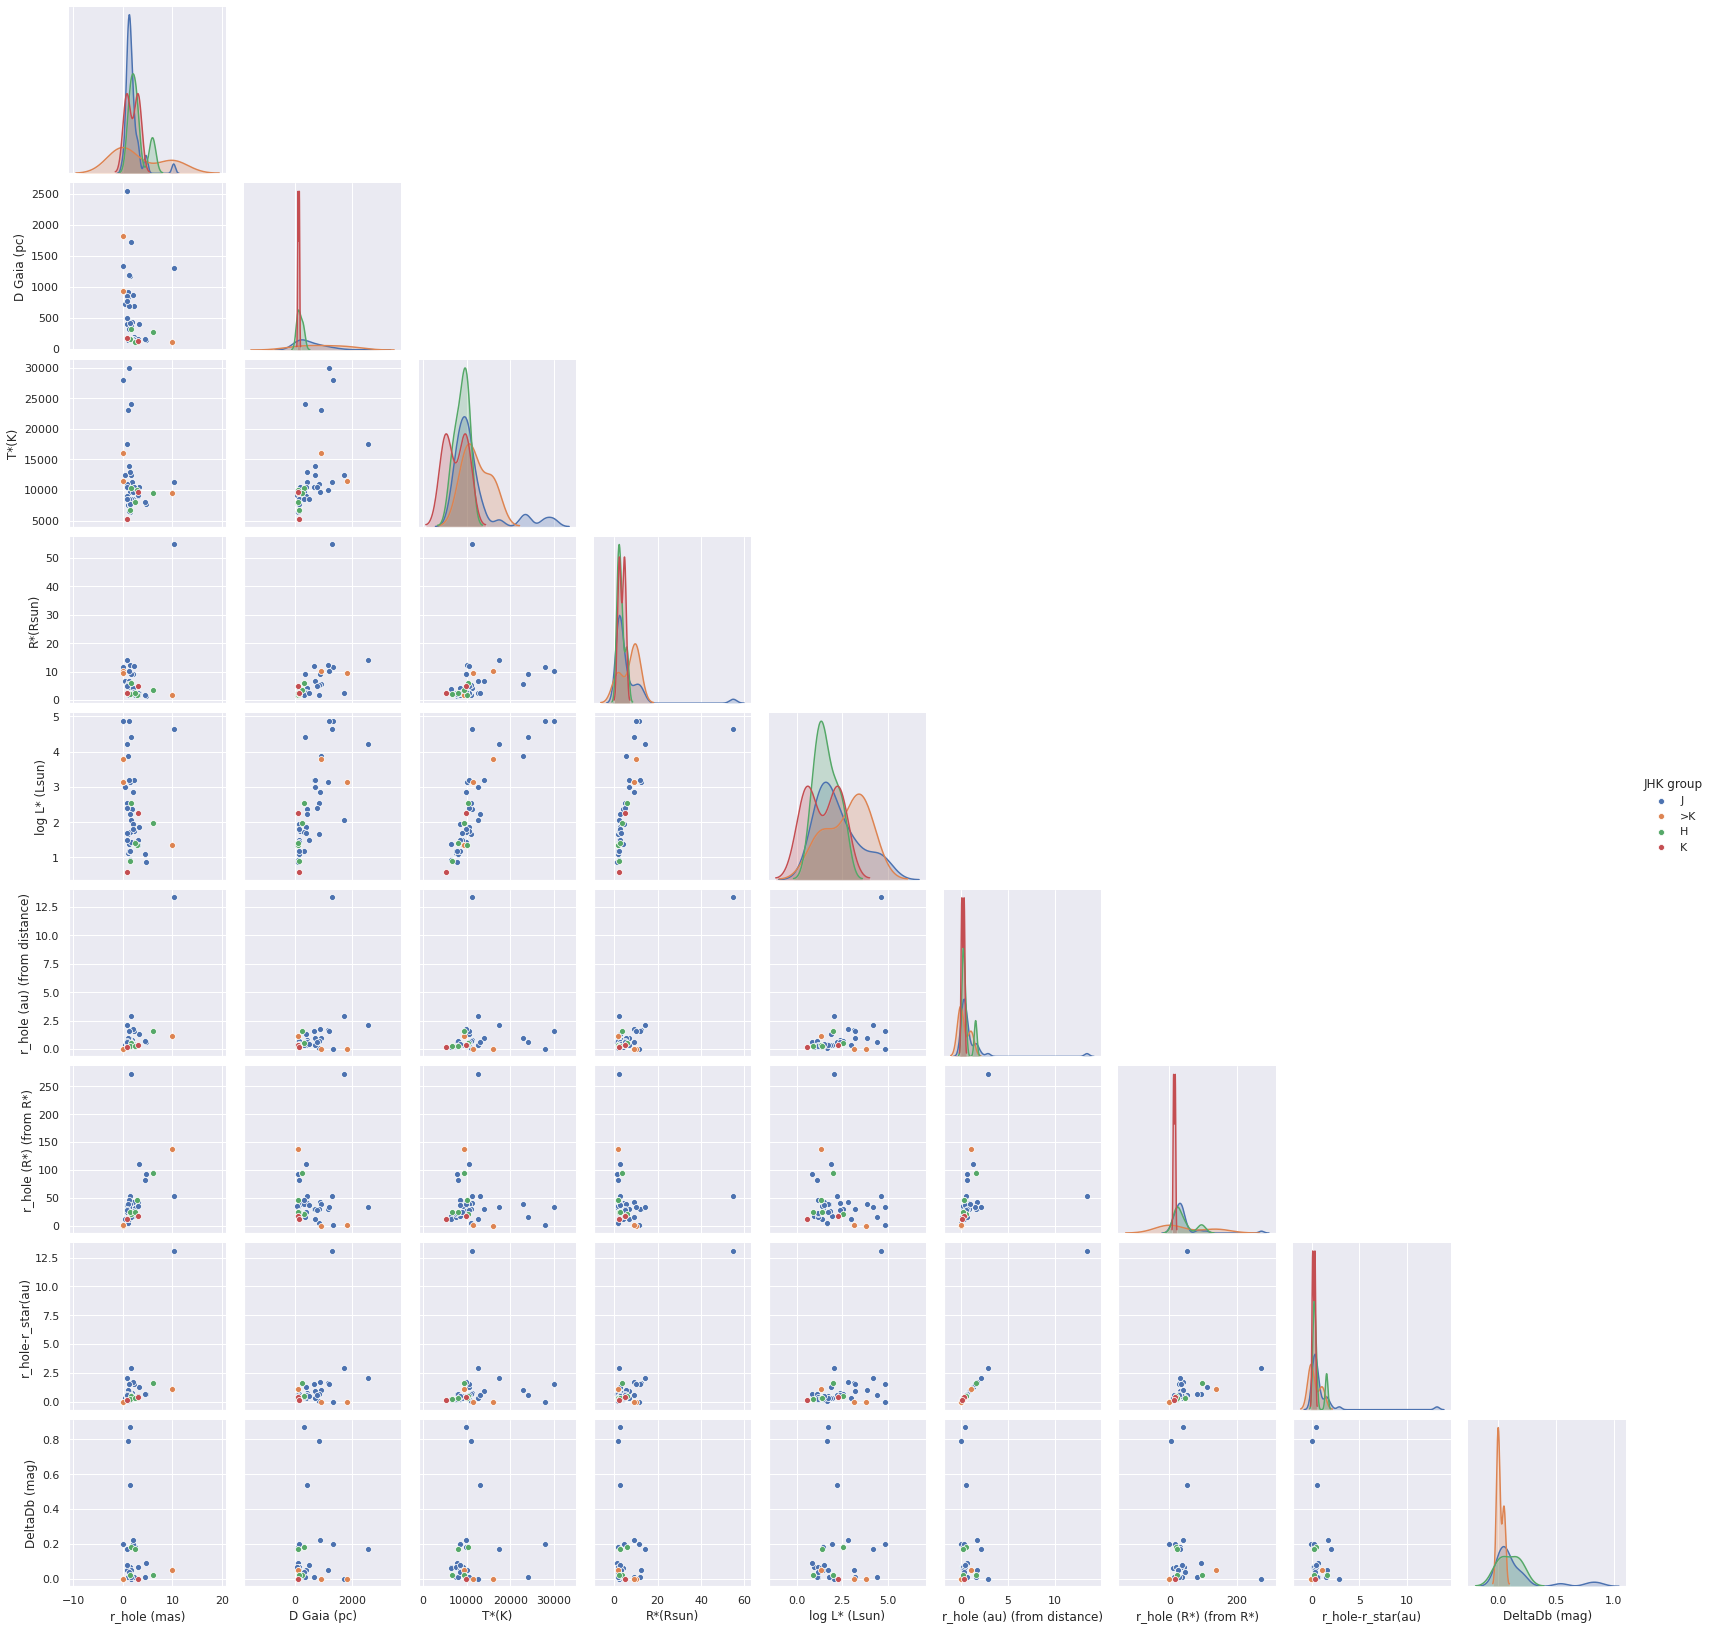

In [9]:
#cba_table_noerror['Meeus group']=pd.Series(size_luminosity_table['Meeus group'])
cba_table_noerror['JHK group']=pd.Series(size_luminosity_table['JHK group'])

sns.pairplot(cba_table_noerror, hue='JHK group', corner=True)

## Variance Inflation Factor
Regression of r_hole variable against log L* (Lsun) and D Gaia (pc) variables.

(from https://www.statology.org/multicollinearity-regression/)

>Utilizing the Variance Inflation Factor (VIF)
Most statistical softwares have the ability to compute VIF for a regression model. The value for VIF starts at 1 and has no upper limit. A general rule of thumb for interpreting VIFs is as follows:

>    * A value of 1 indicates there is no correlation between a given predictor variable and any other predictor variables in the model.
>    * A value between 1 and 5 indicates moderate correlation between a given predictor variable and other predictor variables in the model, but this is often not severe enough to require attention.
>    * A value greater than 5 indicates potentially severe correlation between a given predictor variable and other predictor variables in the model. In this case, the coefficient estimates and p-values in the regression output are likely unreliable.


In [10]:
VIF_table = size_luminosity_table[['r_hole (mas)','D Gaia (pc)',
                                 'T*(K)','R*(Rsun)','log L* (Lsun)',
                                 'r_hole (au) (from distance)','r_hole (R*) (from R*)',
                                 'r_hole-r_star(au)']].copy()
#VIF_table.info


In [11]:
# Let's create a function to create adjusted R-Squared
def adj_r2(x,y):
    r2 = regression.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adjusted_r2

In [12]:
VIF_table.describe(include='all')

,r_hole (mas),D Gaia (pc),T*(K),R*(Rsun),log L* (Lsun),r_hole (au) (from distance),r_hole (R*) (from R*),r_hole-r_star(au)
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,2.147870,575.865208,11679.687500,6.568958,2.314583,1.014844,39.516042,0.984583
std,2.052490,556.381049,6057.399766,9.007012,1.249342,1.977965,44.027357,1.942178
min,0.001696,102.000000,5250.000000,1.490000,0.580000,0.001600,0.030000,-0.050000
25%,1.137387,156.500000,8500.000000,2.295000,1.382500,0.275125,17.730000,0.267500
50%,1.580000,352.500000,9750.000000,2.845000,1.905000,0.453300,29.345000,0.440000
75%,2.412500,862.500000,11312.500000,7.332500,3.130000,1.027325,40.845000,1.010000
max,10.270000,2550.000000,33000.000000,54.830000,5.720000,13.351000,272.060000,13.100000


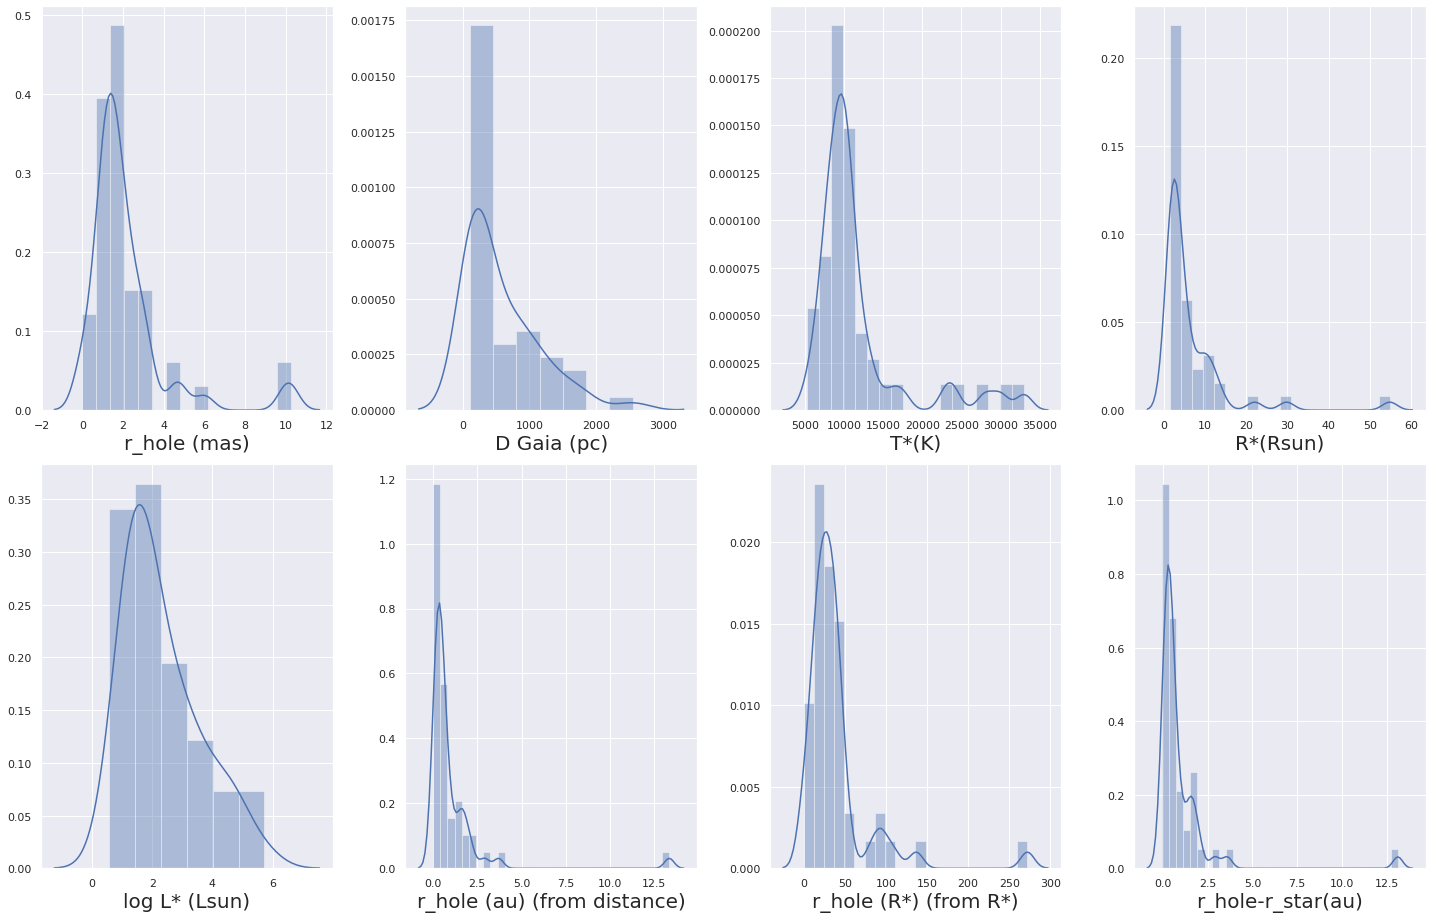

In [13]:
data =VIF_table
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in data:
    if plotnumber<=16 :
        ax = plt.subplot(4,4,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.tight_layout()

In [117]:
y = data['r_hole (au) (from distance)']
X = data.drop(columns = ['r_hole (au) (from distance)'])

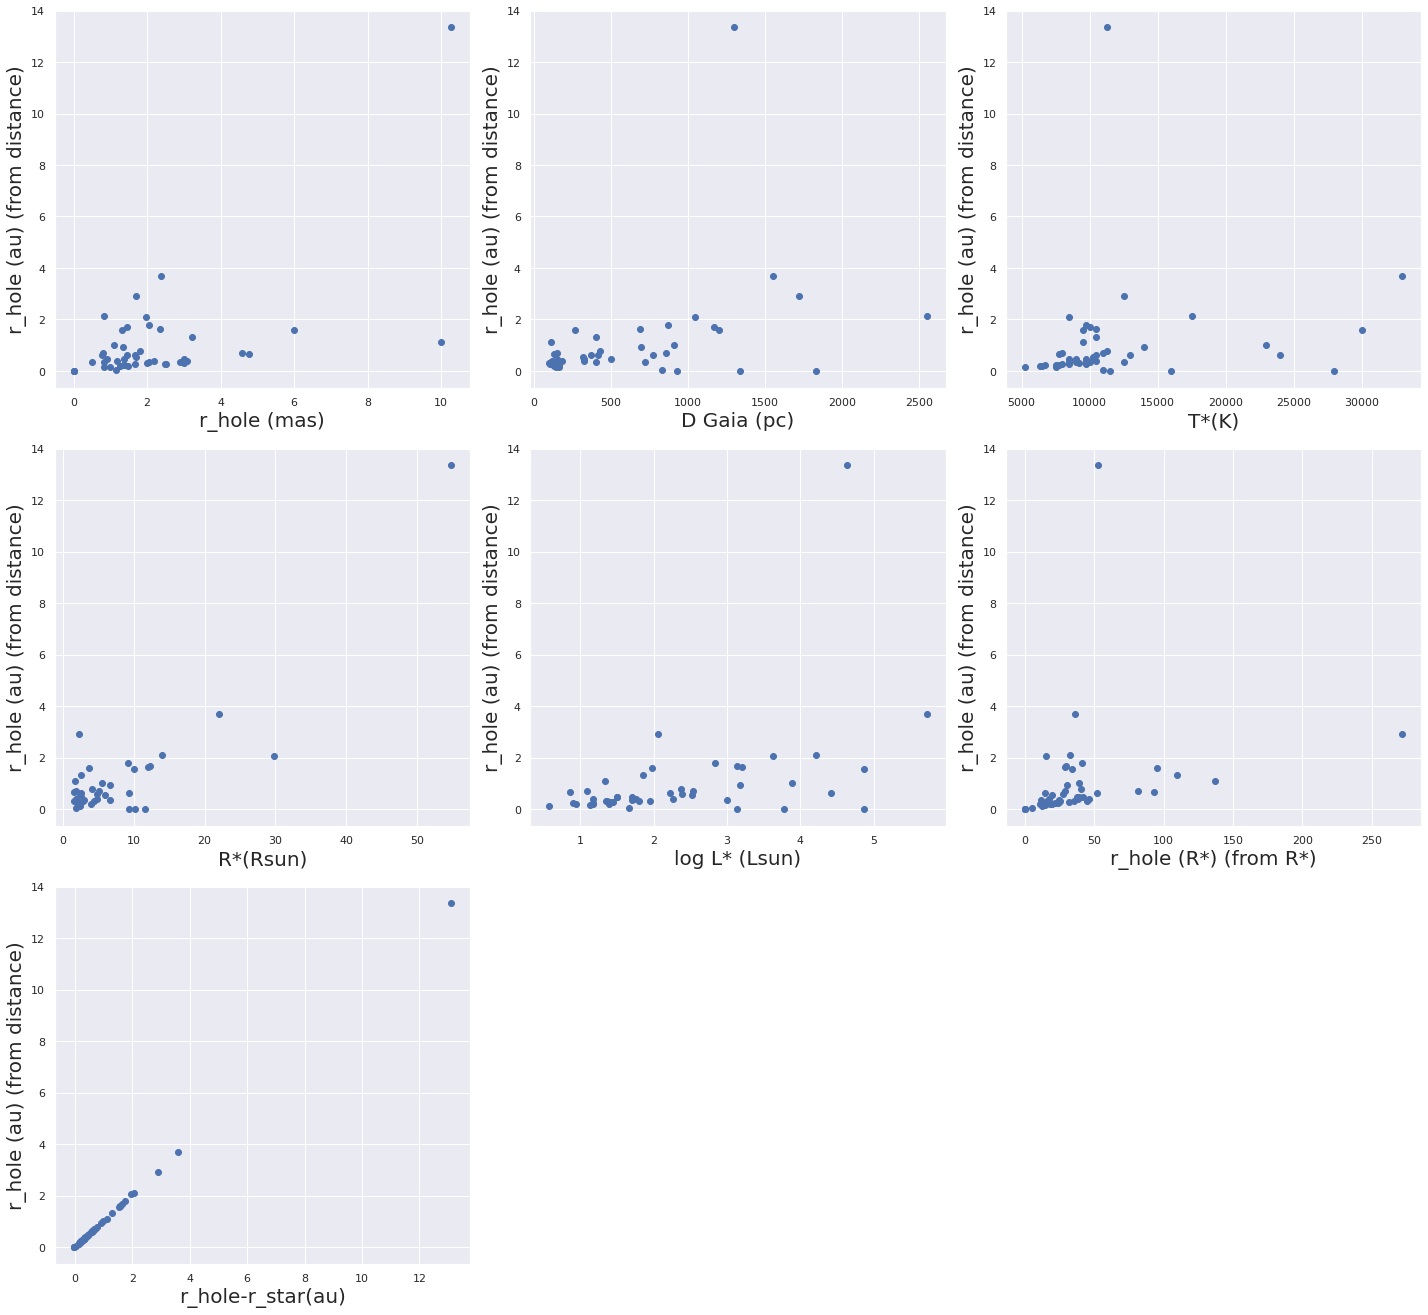

In [118]:

plt.figure(figsize=(20,30), facecolor='white')
plotnumber = 1

for column in X:
    if plotnumber<=15 :
        ax = plt.subplot(5,3,plotnumber)
        plt.scatter(X[column],y)
        plt.xlabel(column,fontsize=20)
        plt.ylabel('r_hole (au) (from distance)',fontsize=20)
    plotnumber+=1
plt.tight_layout()



It is obvious the linear correlation between *r_hole (au) (from distance)* and *r_hole-r_star(au)*, so let's drop this variable and check for multi-collinearity

In [119]:
X = X.drop(columns = ['r_hole-r_star(au)'])

In [120]:
scaler =StandardScaler()

X_scaled = scaler.fit_transform(X)

In [122]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_scaled

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
# we do not include categorical values for mulitcollinearity as they do not provide much information as numerical ones do
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = X.columns

In [123]:
vif.info



<bound method DataFrame.info of          VIF               Features
0   2.947059           r_hole (mas)
1   3.874685            D Gaia (pc)
2   6.940056                  T*(K)
3   5.510430               R*(Rsun)
4  15.186177          log L* (Lsun)
5   2.206905  r_hole (R*) (from R*)>

There is a strong correlation between L* and some of the other variables, as expected. 
Let´s remove these variables not affecting our r_hole vs L* plot and check correlation to distance:  

In [124]:
X = X.drop(columns = ['T*(K)','R*(Rsun)','r_hole (R*) (from R*)'])



In [125]:
scaler =StandardScaler()

X_scaled = scaler.fit_transform(X)

In [126]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_scaled

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
# we do not include categorical values for mulitcollinearity as they do not provide much information as numerical ones do
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = X.columns

vif.info

<bound method DataFrame.info of         VIF       Features
0  1.047917   r_hole (mas)
1  2.317873    D Gaia (pc)
2  2.249212  log L* (Lsun)>

If removing the luminosity instead of 'T*(K)','R*(Rsun)','r_hole (R*) (from R*)' to evaluate independency in the rest of the varables:

In [14]:
X = VIF_table.drop(columns = ['r_hole (au) (from distance)', 'log L* (Lsun)', 'r_hole-r_star(au)'])

scaler =StandardScaler()

X_scaled = scaler.fit_transform(X)

from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_scaled

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
# we do not include categorical values for mulitcollinearity as they do not provide much information as numerical ones do
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = X.columns





In [15]:
vif.info


<bound method DataFrame.info of         VIF               Features
0  2.931239           r_hole (mas)
1  3.237967            D Gaia (pc)
2  1.479620                  T*(K)
3  3.212915               R*(Rsun)
4  2.092535  r_hole (R*) (from R*)>

In [20]:
# saving the model in local
filename = 'finalized_model.pickle'
pickle.dump(regression, open(filename, 'wb'))

NameError: name 'regression' is not defined

In [22]:




X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     71.23
Date:                Fri, 02 Oct 2020   Prob (F-statistic):           2.07e-19
Time:                        11:39:29   Log-Likelihood:                -46.363
No. Observations:                  48   AIC:                             104.7
Df Residuals:                      42   BIC:                             116.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.79